# ES-RNN model 

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement an ES-RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses recent values of load as the model input. The model will be trained to output a vector, the elements of which are ordered predictions for future time steps.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict, deque
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load data into Pandas dataframe

In [2]:
energy = load_data('data/')
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=3* specifies that we have a forecasting horizon of 3 (*t+3*)

In [3]:
valid_start_dt = '2014-08-30 08:00:00'
test_start_dt = '2014-10-31 11:00:00'
test_end_dt = '2014-12-30 18:00:00'

T = 6
HORIZON = 3

Create training set.

In [4]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train[['load']])
train[['load']] = scaler.transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [6]:
tensor_structure = {'X':(range(-T+1, 1), ['load'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [7]:
train_inputs.dataframe.head(3)

tensor              target              X                         
feature                  y           load                         
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23

In [8]:
print("y_train shape: ", train_inputs['target'].shape)
print("x_train shape: ", train_inputs['X'].shape)

y_train shape:  (23328, 3)
x_train shape:  (23328, 6, 1)


In [9]:
train_inputs['X'][:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [10]:
train_inputs['target'][:3]

array([[0.18, 0.23, 0.29],
       [0.23, 0.29, 0.35],
       [0.29, 0.35, 0.37]])

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [11]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid[['load']] = scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement ES-RNN

We will implement ES-RNN forecasting model with the following structure:

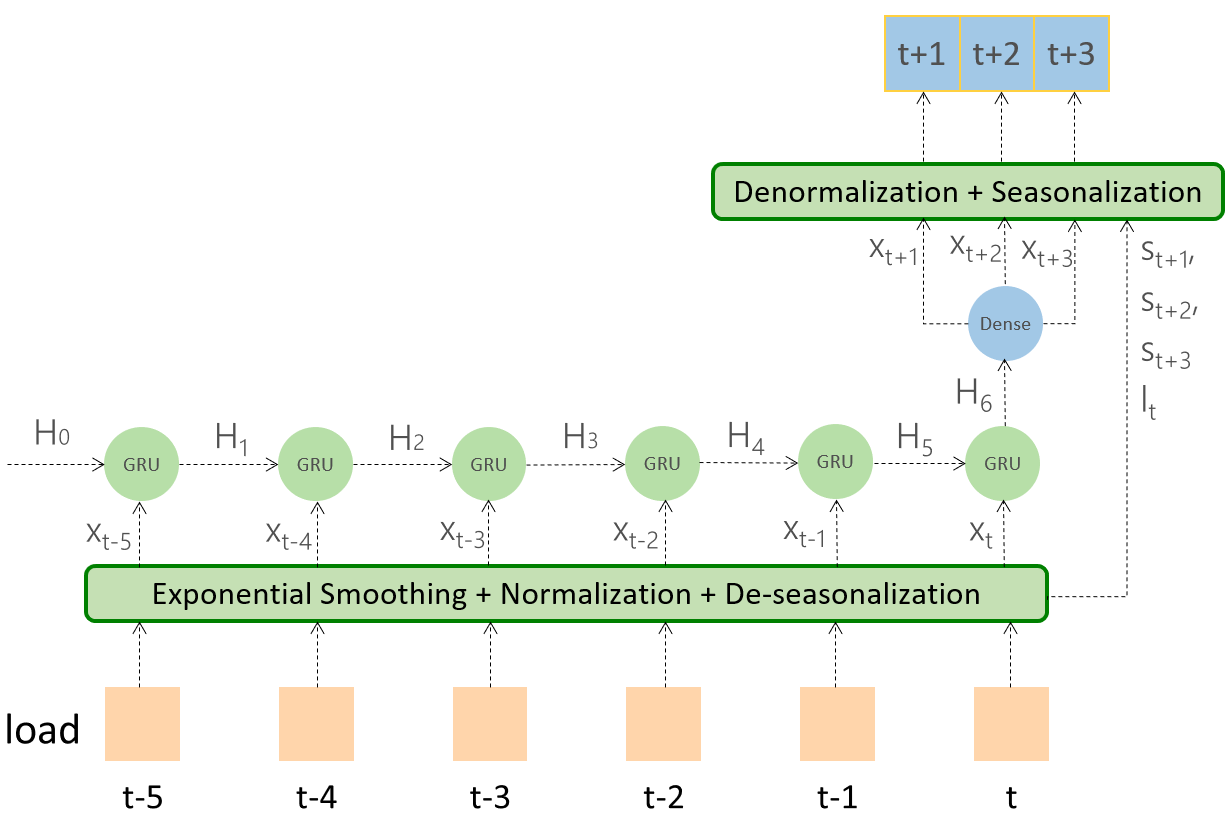

In [12]:
Image('./images/es_rnn.png')

In [13]:
from keras.models import Model
from keras.layers import Input, GRU, Dense, Lambda
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [14]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 48 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples
m = 24 # seasonality length

### Create custom layers in Keras
In this section we define two custom layers:
- ***ES*** layer: This layer implements the Expomemtial Smoothing,  normalization and de-seasonalization for input data.
- ***Denormalization*** layer: This layer takes the normalization and de-seasonalization coefficients from ES layer and multiply them to output of RNN for de-normalization and seasonalization.


There are 3 methods you need to implement in your custom layer:
- build(input_shape): this is where you will define your weights.
- call(x): this is where the layer's logic lives.
- compute_output_shape(input_shape): in case your layer modifies the shape of its input, you should specify here the shape transformation logic. 

You can check [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/) for more details about creating custom layer.

In [15]:
from keras import backend as K
from keras.layers import Layer
from keras import initializers

# Exponential Smoothing + Normalization
class ES(Layer):

    def __init__(self, horizon, m, batch_size, time_steps, **kwargs):
        self.horizon = horizon
        self.m = m
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        super(ES, self).__init__(**kwargs)

    # initialization of the learned parameters of exponential smoothing
    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.init_seasonality = self.add_weight(name='init_seasonality', shape=(self.m,),
                                                initializer=initializers.Constant(value=0.8), trainable=True)
        self.init_seasonality_list = [K.slice(self.init_seasonality,(i,),(1,)) for i in range(self.m)]
        self.seasonality_queue = deque(self.init_seasonality_list, self.m)
        self.level = self.add_weight(name='init_level', shape=(1,),
                                     initializer=initializers.Constant(value=0.8), 
                                     trainable=True)
        super(ES, self).build(input_shape)  

    def call(self, x):

        # extract time-series from feature vector
        n_examples = K.int_shape(x)[0]
        if n_examples is None:
            n_examples = self.batch_size
        x1 = K.slice(x,(0,0,0),(1,self.time_steps,1))
        x1 = K.reshape(x1,(self.time_steps,))
        x2 = K.slice(x,(1,self.time_steps-1,0),(n_examples-1,1,1))
        x2 = K.reshape(x2,(n_examples-1,))
        ts = K.concatenate([x1,x2])
        
        x_norm = []  # normalized values of time-series
        ls = []      # coeffients for denormalization of forecasts
        
        l_t_minus_1 = self.level
        
        for i in range(n_examples+self.time_steps-1):
        
            # compute l_t
            y_t = ts[i]
            s_t = self.seasonality_queue.popleft()
            l_t = self.alpha * y_t / s_t + (1 - self.alpha) * l_t_minus_1
            
            # compute s_{t+m}
            s_t_plus_m = self.gamma * y_t / l_t + (1 - self.gamma) * s_t
            
            self.seasonality_queue.append(s_t_plus_m)
            
            # normalize y_t
            x_norm.append(y_t / (s_t * l_t))

            l_t_minus_1 = l_t

            if i >= self.time_steps-1:
                l = [l_t]*self.horizon
                l = K.concatenate(l)
                s = [self.seasonality_queue[i] for i in range(self.horizon)] # we assume here that horizon < m
                s = K.concatenate(s)
                ls_t = K.concatenate([K.expand_dims(l), K.expand_dims(s)])
                ls.append(K.expand_dims(ls_t,axis=0))  
       
        self.level = l_t
        x_norm = K.concatenate(x_norm)

        # create x_out
        x_out = []
        for i in range(n_examples):
            norm_features = K.slice(x_norm,(i,),(self.time_steps,))
            norm_features = K.expand_dims(norm_features,axis=0)
            x_out.append(norm_features)

        x_out = K.concatenate(x_out, axis=0)
        x_out = K.expand_dims(x_out)

        # create tensor of denormalization coefficients 
        denorm_coeff = K.concatenate(ls, axis=0)
        return [x_out, denorm_coeff]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2]), (input_shape[0], self.horizon, 2)]
    
class Denormalization(Layer):
    
    def __init__(self, **kwargs):
        super(Denormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Denormalization, self).build(input_shape)  

    def call(self, x):
        return x[0] * x[1][:,:,0] * x[1][:,:,1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

### Create ES-RNN model
Since Denormalization layer has inputs from two previous layers, we need to use functional API of Keras to create the model.

In [16]:
model_input = Input(shape=(None, 1))
[normalized_input, denormalization_coeff] = ES(HORIZON, m, BATCH_SIZE, T)(model_input)
gru_out = GRU(LATENT_DIM)(normalized_input)
model_output_normalized = Dense(HORIZON)(gru_out)
model_output = Denormalization()([model_output_normalized, denormalization_coeff])
model = Model(inputs=model_input, outputs=model_output)

In [17]:
model.compile(optimizer='RMSprop', loss='mse')

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
es_1 (ES)                       [(None, None, 1), (N 27          input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 5)            105         es_1[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            18          gru_1[0][0]                      
__________________________________________________________________________________________________
denormaliz

In [19]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)

In [20]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          shuffle=False,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Train on 23328 samples, validate on 1488 samples
Epoch 1/10
23328/23328 [==============================] - 8s 341us/step - loss: 0.0324 - val_loss: 0.0194
Epoch 2/10
23328/23328 [==============================] - 4s 153us/step - loss: 0.0029 - val_loss: 0.0184
Epoch 3/10
23328/23328 [==============================] - 4s 156us/step - loss: 0.0023 - val_loss: 0.0163
Epoch 4/10
23328/23328 [==============================] - 4s 155us/step - loss: 0.0019 - val_loss: 0.0140
Epoch 5/10
23328/23328 [==============================] - 4s 157us/step - loss: 0.0016 - val_loss: 0.0120
Epoch 6/10
23328/23328 [==============================] - 4s 154us/step - loss: 0.0015 - val_loss: 0.0103
Epoch 7/10
23328/23328 [==============================] - 4s 154us/step - loss: 0.0014 - val_loss: 0.0091
Epoch 8/10
23328/23328 [==============================] - 4s 156us/step - loss: 0.0013 - val_loss: 0.0081
Epoch 9/10
23328/23328 [==============================] - 4s 154us/step - loss: 0.0012 - val_loss: 0.00

## Evaluate the model

In [21]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:test_end_dt][['load']]
test[['load']] = scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [22]:
predictions = model.predict(test_inputs['X'], batch_size=BATCH_SIZE)

In [23]:
predictions

array([[0.54, 0.69, 0.72],
       [0.48, 0.61, 0.63],
       [0.46, 0.55, 0.57],
       ...,
       [0.58, 0.59, 0.68],
       [0.6 , 0.69, 0.77],
       [0.69, 0.78, 0.76]], dtype=float32)

In [24]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-10-31 16:00:00,t+1,"3,717.48","3,437.00"
1,2014-10-31 17:00:00,t+1,"3,543.91","3,466.00"
2,2014-10-31 18:00:00,t+1,"3,483.05","3,374.00"
3,2014-10-31 19:00:00,t+1,"3,409.18","3,315.00"
4,2014-10-31 20:00:00,t+1,"3,340.66","3,142.00"


Compute MAPE for each forecast horizon

In [25]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.03
t+2   0.08
t+3   0.11
Name: APE, dtype: float64

Compute MAPE across all predictions

In [26]:
mape(eval_df['prediction'], eval_df['actual'])

0.07506279816956267

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

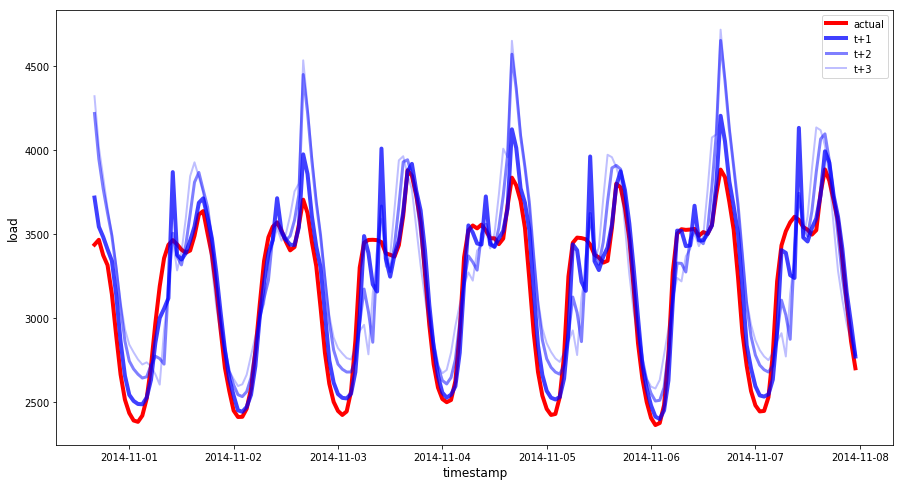

In [27]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()